<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/schrodinger/schrodinger_base__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using cuda
Epoch 0, Loss: 4.539968e-02, E: 0.501000
Epoch 500, Loss: 7.511928e-06, E: 0.508021
Epoch 1000, Loss: 2.368700e-06, E: 0.500610
Epoch 1500, Loss: 1.632175e-06, E: 0.502234
Epoch 2000, Loss: 1.024668e-06, E: 0.502414
Epoch 2500, Loss: 6.655848e-07, E: 0.504280
Epoch 3000, Loss: 4.557981e-07, E: 0.507802
Epoch 3500, Loss: 3.931257e-07, E: 0.516751
Epoch 4000, Loss: 7.886238e-07, E: 0.517444
Epoch 4500, Loss: 1.469930e-05, E: 0.531296
Epoch 5000, Loss: 5.272038e-08, E: 0.543472
Epoch 5500, Loss: 3.412629e-08, E: 0.562123
Epoch 6000, Loss: 2.266179e-08, E: 0.582005
Epoch 6500, Loss: 8.520257e-08, E: 0.601946
Epoch 7000, Loss: 1.097811e-07, E: 0.641290
Epoch 7500, Loss: 2.002009e-08, E: 0.666465
Epoch 8000, Loss: 4.966965e-06, E: 0.686174
Epoch 8500, Loss: 1.162042e-08, E: 0.727370
Epoch 9000, Loss: 1.366617e-08, E: 0.760700
Epoch 9500, Loss: 4.540306e-09, E: 0.787944
Final learned energy: 0.838796


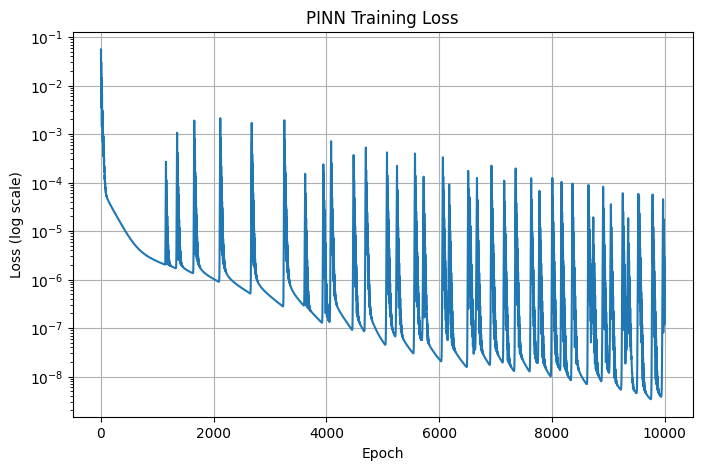

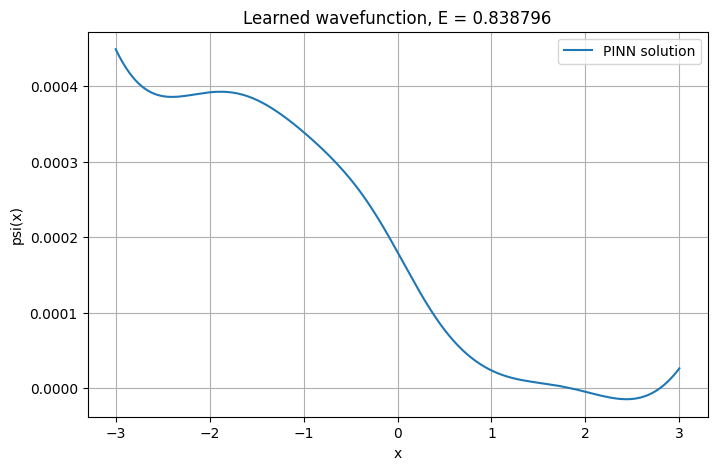

In [5]:
# -----------------------
# Imports
# -----------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

# -----------------------
# Problem Definition
# -----------------------
L = 3.0                      # domain half-width
domain = [-L, L]
V = lambda x: 0.5 * x**2     # harmonic oscillator potential

# -----------------------
# PINN definition
# -----------------------
class SchrodingerPINN(nn.Module):
    def __init__(self, hidden_dim=50, hidden_layers=3):
        super().__init__()
        layers = []
        layers.append(nn.Linear(1, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
        # learnable energy parameter
        self.E = nn.Parameter(torch.tensor(0.5, device=device))  # initial guess
    def forward(self, x):
        return self.net(x)

# -----------------------
# Model + Optimizer
# -----------------------
model = SchrodingerPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# Collocation points
# -----------------------
N_colloc = 10000
x_colloc = torch.linspace(domain[0], domain[1], N_colloc, device=device).view(-1,1)
x_colloc.requires_grad_(True)

# Boundary points
x_bc = torch.tensor([[domain[0]], [domain[1]]], device=device)

# -----------------------
# Training loop
# -----------------------
loss_history = []
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()

    # network prediction
    psi = model(x_colloc)

    # first derivative
    psi_x = torch.autograd.grad(psi, x_colloc, torch.ones_like(psi), create_graph=True)[0]
    # second derivative
    psi_xx = torch.autograd.grad(psi_x, x_colloc, torch.ones_like(psi_x), create_graph=True)[0]

    # residual
    residual = psi_xx + 2*(model.E - V(x_colloc)) * psi
    loss_pde = torch.mean(residual**2)

    # boundary loss
    psi_bc = model(x_bc)
    loss_bc = torch.mean(psi_bc**2)

    # total loss
    loss = loss_pde + loss_bc

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6e}, E: {model.E.item():.6f}")

print(f"Final learned energy: {model.E.item():.6f}")

# -----------------------
# Plotting
# -----------------------
plt.figure(figsize=(8,5))
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("PINN Training Loss")
plt.grid()
plt.show()

# Final wavefunction plot
x_plot = torch.linspace(domain[0], domain[1], 500, device=device).view(-1,1)
with torch.no_grad():
    psi_plot = model(x_plot).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(x_plot.cpu().numpy(), psi_plot, label="PINN solution")
plt.xlabel("x")
plt.ylabel("psi(x)")
plt.title(f"Learned wavefunction, E = {model.E.item():.6f}")
plt.grid()
plt.legend()
plt.show()
